In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import pyfftw.interfaces.numpy_fft as fft
import pyfftw
import galsim

from scripts import BTK_generator

# 0. Goals

The goal of this notebook is to be able to tap into the different stages of the `isolated_images`. That is:
- `isolated_images` with PSF and noise $\leftarrow$ **Done**
- `isolated_images` with just PSF
- `isolated_images` with **NO** PSF **or** noise.

This is important because to do work with blending we need to know the PSF. So, what we want is:

1. A centered image of the PSF. This PSF is applied to the isolated galaxy images. $\leftarrow$ **Done**
    1. We want this because we are going to deconvolve the PSF from the galaxy image, so we need a noise-free image of the PSF.
    
2. The isolated galaxy images **BEFORE** the PSF is applied.
    1. With (1.) we take the FT of the galaxy images and the FT of the centered PSF and divide the FT galaxy by the FT of the PSF. Doing this in FS is equivalent to a deconvolution in the spatial domain. Once done, IFT back into the spatial domain and now you have the image of the isolated galaxy **before** application of PSF.
        2. NOTE: This is what the galaxy would look like from a space-based telescope.
        
3. The isolated galaxy images with PSF, but **no noise**.
    1. Just set the `add_noise` parameter in the blend generator to `None`. 
        2. NOTE: Pretty sure they are already noise free, but good to check.
    
    

# 1. Testing

## 1.1 Creating the centered PSF

In [ ]:
BTK_generator(catalog_name=None,
              stamp_size=24.0,
              max_number=1,
              max_shift=0,
              batch_size=10,
              sampling_func=None,
              survey="LSST",
              add_noise="all")

In [ ]:
BTK_generator(catalog_name=None,
             stamp)

In [2]:
# Catalog:
#---------#
catalog_name = "/Users/matt/Desktop/UCI_Research/LSST/btk_blending/DS_creation/Data/OneDegSq.fits"
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)

# Setting parameter values:
#-------------------#
stamp_size = 24.0 # Size of the stamp, in arcseconds
max_number = 3 # Max number of galaxies in a blend
max_shift = 0.0 # Max shift of the galaxies from center, in arcseconds

# Sampling Function:
#-------------------#
sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number,
                                                          stamp_size=stamp_size,
                                                          maxshift=max_shift)

# Survey
#-------#
LSST = btk.survey.get_surveys("LSST")

# Draw Blends:
#-------------#
draw_generator = btk.draw_blends.CatsimGenerator(
    catalog=catalog,
    sampling_function=sampling_function,
    surveys=LSST,
    batch_size=10,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="none", 
    seed=1)

# Sample the blends from the blends generator:
#----------------------------------------------#
batch = next(draw_generator)
blend_images = batch['blend_images']
blend_list = batch['blend_list']
isolated_images = batch['isolated_images']
psf = batch['psf']
wcs = batch['wcs']

# Set plotting params:
#---------------------#
indx = 0    # Sample number
cindx = 2   # Channel index (band number has 6 filters for LSST)
oindx = 0   # Object index (for the isolated images)

Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

To print the attributes of an object use: `object.__dict__`. E.g. `PSF.__dict__`

To get the attributes of an object use `getattr`: E.g. `getattr(PSF, '_array')`

In [3]:
def create_PSF_image(psf_obj, blend_imgs):
    """
    Function that retrieves and creates 6 PSF images for each
    LSST filter. 
    
    Args:
    -----
    psf_obj: list
        List of galsim.convolve.Convolution objects. It stores 
        pertinent information regarding the PSF for each LSST
        filter.
        
    Returns:
    --------
    psf_arr: list
        A list of the 2D PSF np.ndarrays for each filter.
    """
    psf_arr = []
    for i in range(len(psf)):
        image_epsf = galsim.ImageF(blend_imgs.shape[-1], blend_imgs.shape[-1])
        psf_obj = psf[i].drawImage(image_epsf, scale=0.2)
        psf_img = getattr(psf_obj, '_array')
        psf_arr.append(psf_img)
        
    return psf_arr

**Plot of the 6 LSST filter PSF images**

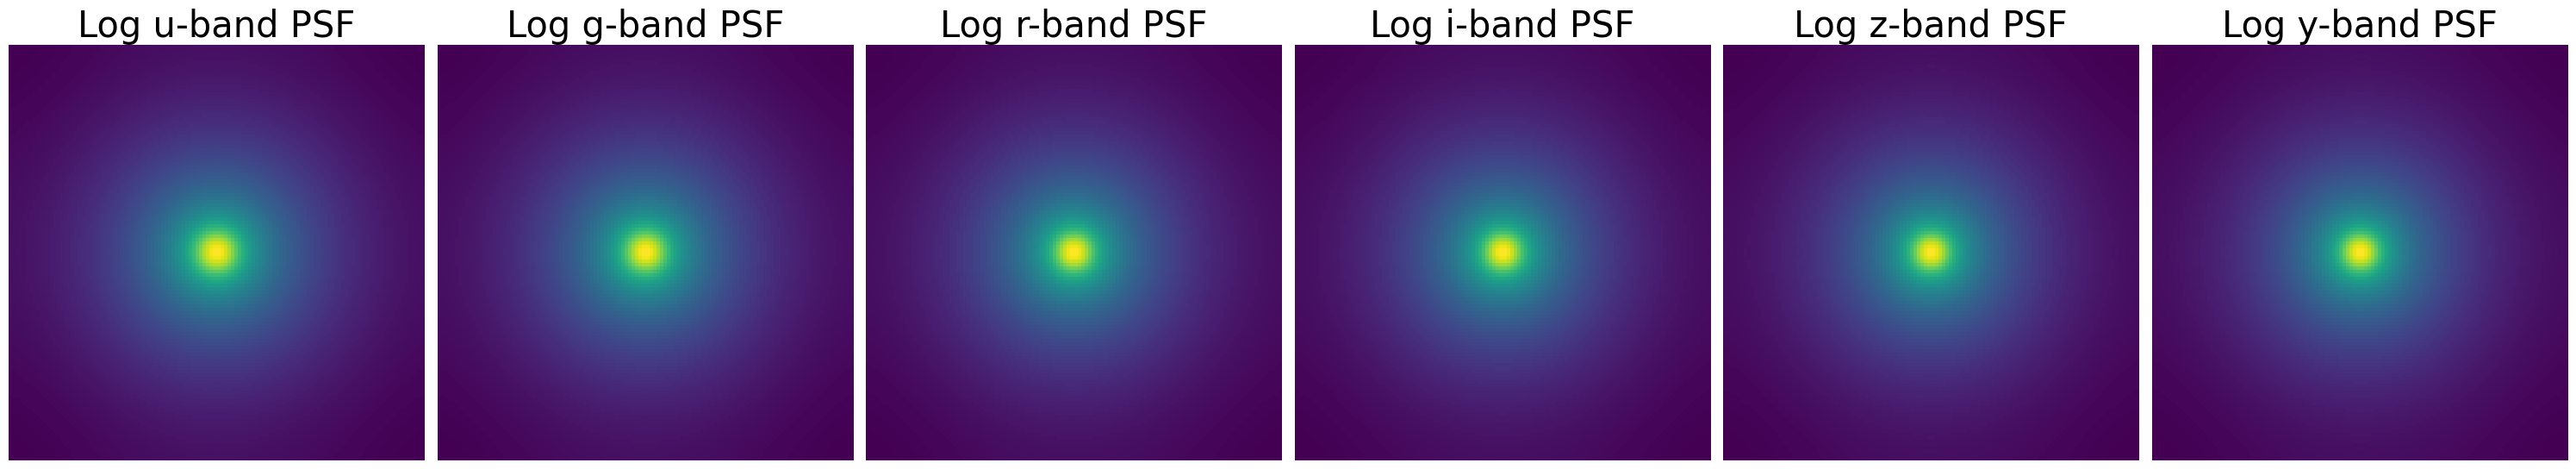

In [4]:
psf_imgs = create_PSF_image(psf_obj=psf, blend_imgs=blend_images)

fig, axes = plt.subplots(1, 6, figsize=(30,26))
axes[0].imshow(np.log(psf_imgs[0]))
axes[0].axis('off')
axes[0].set_title('Log u-band PSF', fontsize=30)
axes[1].imshow(np.log(psf_imgs[1]))
axes[1].axis('off')
axes[1].set_title('Log g-band PSF', fontsize=30)
axes[2].imshow(np.log(psf_imgs[2]))
axes[2].axis('off')
axes[2].set_title('Log r-band PSF', fontsize=30)
axes[3].imshow(np.log(psf_imgs[3]))
axes[3].axis('off')
axes[3].set_title('Log i-band PSF', fontsize=30)
axes[4].imshow(np.log(psf_imgs[4]))
axes[4].axis('off')
axes[4].set_title('Log z-band PSF', fontsize=30)
axes[5].imshow(np.log(psf_imgs[5]))
axes[5].axis('off')
axes[5].set_title('Log y-band PSF', fontsize=30)

plt.tight_layout()
plt.show()

## 1.2 Creating the deconvolved galaxy images

These cells are meant to get the galaxy images as if theye were observed from space (ie. no PSF). To accomplish this we must FT both the PSF image, as well as, the galaxy image. Once in FS, a deconvolution is a simple division, which we compute and then IFT back into the spatial domain. This description is shown mathematically below:

$$ F^{-1}\big( \frac{\psi_{i}}{p_{k}} \big),$$

where:
- $\psi_i$ is the FT of the galaxy
- $p_{k}$ is the FT of the PSF
- $\frac{\psi_{i}}{p_{k}}$ is the deconvolution in FS
- $F^{-1}$ is the IFT of the deconvolved galaxy image.

We start with creating the galaxy and PSF images.

In [5]:
# Catalog:
#---------#
catalog_name = "/Users/matt/Desktop/UCI_Research/LSST/btk_blending/DS_creation/Data/OneDegSq.fits"
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)

# Setting parameter values:
#-------------------#
stamp_size = 24.0 # Size of the stamp, in arcseconds
max_number = 3 # Max number of galaxies in a blend
max_shift = 0.0 # Max shift of the galaxies from center, in arcseconds

# Sampling Function:
#-------------------#
sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number,
                                                          stamp_size=stamp_size,
                                                          maxshift=max_shift)

# Survey
#-------#
LSST = btk.survey.get_surveys("LSST")

# Draw Blends:
#-------------#
draw_generator = btk.draw_blends.CatsimGenerator(
    catalog=catalog,
    sampling_function=sampling_function,
    surveys=LSST,
    batch_size=10,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="none", 
    seed=1)

# Sample the blends from the blends generator:
#----------------------------------------------#
batch = next(draw_generator)
blend_images = batch['blend_images']
blend_list = batch['blend_list']
isolated_images = batch['isolated_images']

psf = batch['psf']
psf_images = create_PSF_image(psf_obj=psf, blend_imgs=blend_images)

Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

**Plots of FT/IFT of galaxy images:**

In [6]:
# FT Calc
def FT_IFT_calc(img, FT=True):
    """
    Calculates the FT or IFT of an image. When computing the FT
    we return the power (ie. the complex valued FT), the magnitude 
    (ie. the L2-norm of the complex valued FT array), and we get the
    phase (ie. the angular offset the FT has).
    
    Args:
    -----
        img: np.ndarray
            2D image of galaxy's or PSFs
        FT: boolean
            Boolean to toggle between computing the FT or the IFT.
            The default is FT=True.
    Returns:
    --------
   
    """
    if FT is True:        
        f = fft.fft2(img)
        fshift = fft.fftshift(f)
        magnitude_spectrum = np.log(1 + np.abs(fshift))
        return f, fshift, magnitude_spectrum
    
    else:
        f_ishift = fft.ifftshift(img)
        ift_img = fft.ifft2(f_ishift)
        ift_img = np.real(ift_img)
        return ift_img
    

def visualize_FT_pipeline(img):
    """
    Visualize the process of:
        Image -> FT(Image) -> IFT(FT(Image)) == Image
        
    Visual test that I'm implementing the FT/IFT correctly.
    
    Args:
    -----
        img: np.ndarray
            2D image array
    
    Returns:
    --------
        plt.plot of the input image, FT of input image, IFT of the
        FT'd input image.
    """
    f, fshift, magnitude = FT_IFT_calc(img)
    ift_img = FT_IFT_calc(fshift, FT=False)
    
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(30,26))
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('Input Image', fontsize=30)
    axes[1].imshow(magnitude)
    axes[1].axis('off')
    axes[1].set_title('FT of Input', fontsize=30)
    axes[2].imshow(ift_img)
    axes[2].axis('off')
    axes[2].set_title("IFT of FT'd input", fontsize=30)
    print('Does the input image match the IFT output =', np.allclose(img, ift_img))

Does the input image match the IFT output = True


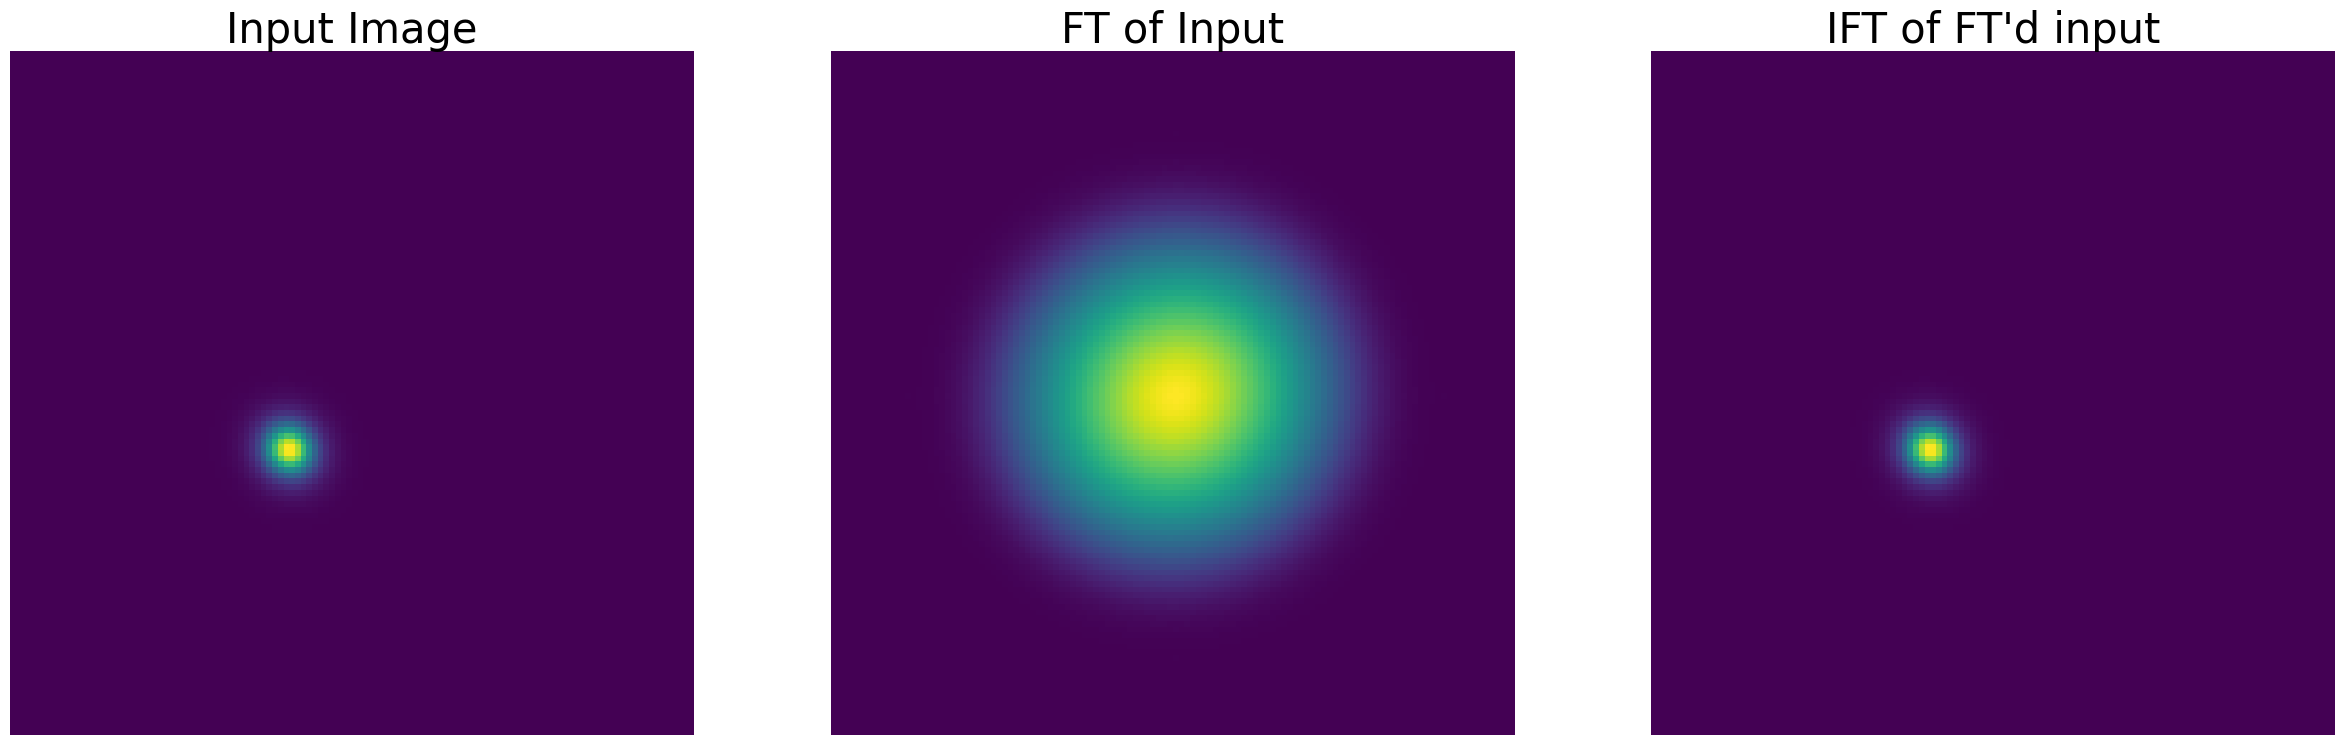

In [7]:
# Processing the data to be in the correct format for pyfftw
gal = isolated_images[0][0][0]
H_gal, W_gal = gal.shape
gal_arr = pyfftw.empty_aligned((H_gal, W_gal), dtype=np.float64)
gal_arr[:, :] = gal

visualize_FT_pipeline(gal)

**Plots of FT/IFT of PSF images:**

Does the input image match the IFT output = True


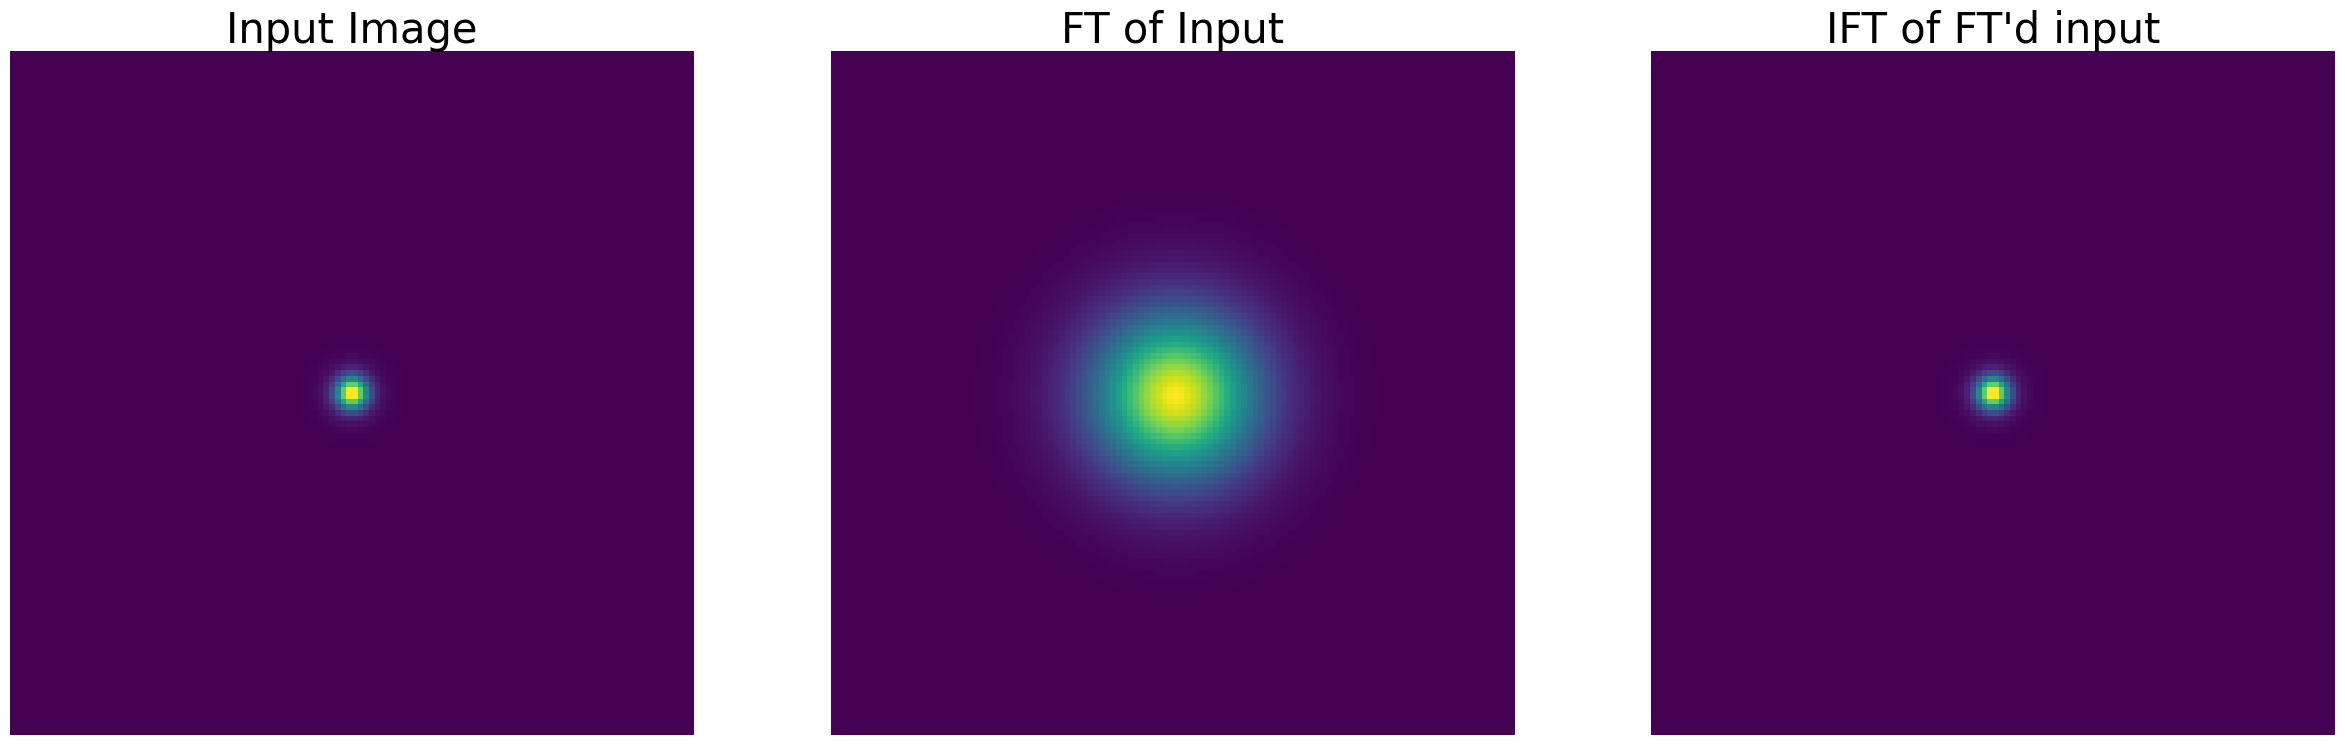

In [9]:
psf_img = psf_images[0]
H_psf, W_psf = psf_img.shape
psf = pyfftw.empty_aligned((H_psf, W_psf), dtype=np.float64)
psf[:, :] = psf_img

visualize_FT_pipeline(psf)

**Plots of the Deconvolved Galaxy Image**

In [10]:
# FT calculations for galaxy image
#----------------------------------#

# Processing the data to be in the correct format for pyfftw
gal = isolated_images[0][0][0] # Sample 1, galaxy 1, filter 1 (u-band)
H, W = gal.shape
gal_arr = pyfftw.empty_aligned((H, W), dtype=np.float64)
gal_arr[:, :] = gal

# FT calc
ft_gal, fshift_gal, mag_gal = FT_IFT_calc(gal_arr, FT=True)

# FT calculations for PSF image
#------------------------------#
# Processing the data to be in the correct format for pyfftw
psf_img = psf_images[0] # Filter 1 ie. u-band
psf = pyfftw.empty_aligned((H, W), dtype=np.float64)
psf[:, :] = psf_img

# FT Calc
ft_psf, fshift_psf, mag_psf = FT_IFT_calc(psf, FT=True)

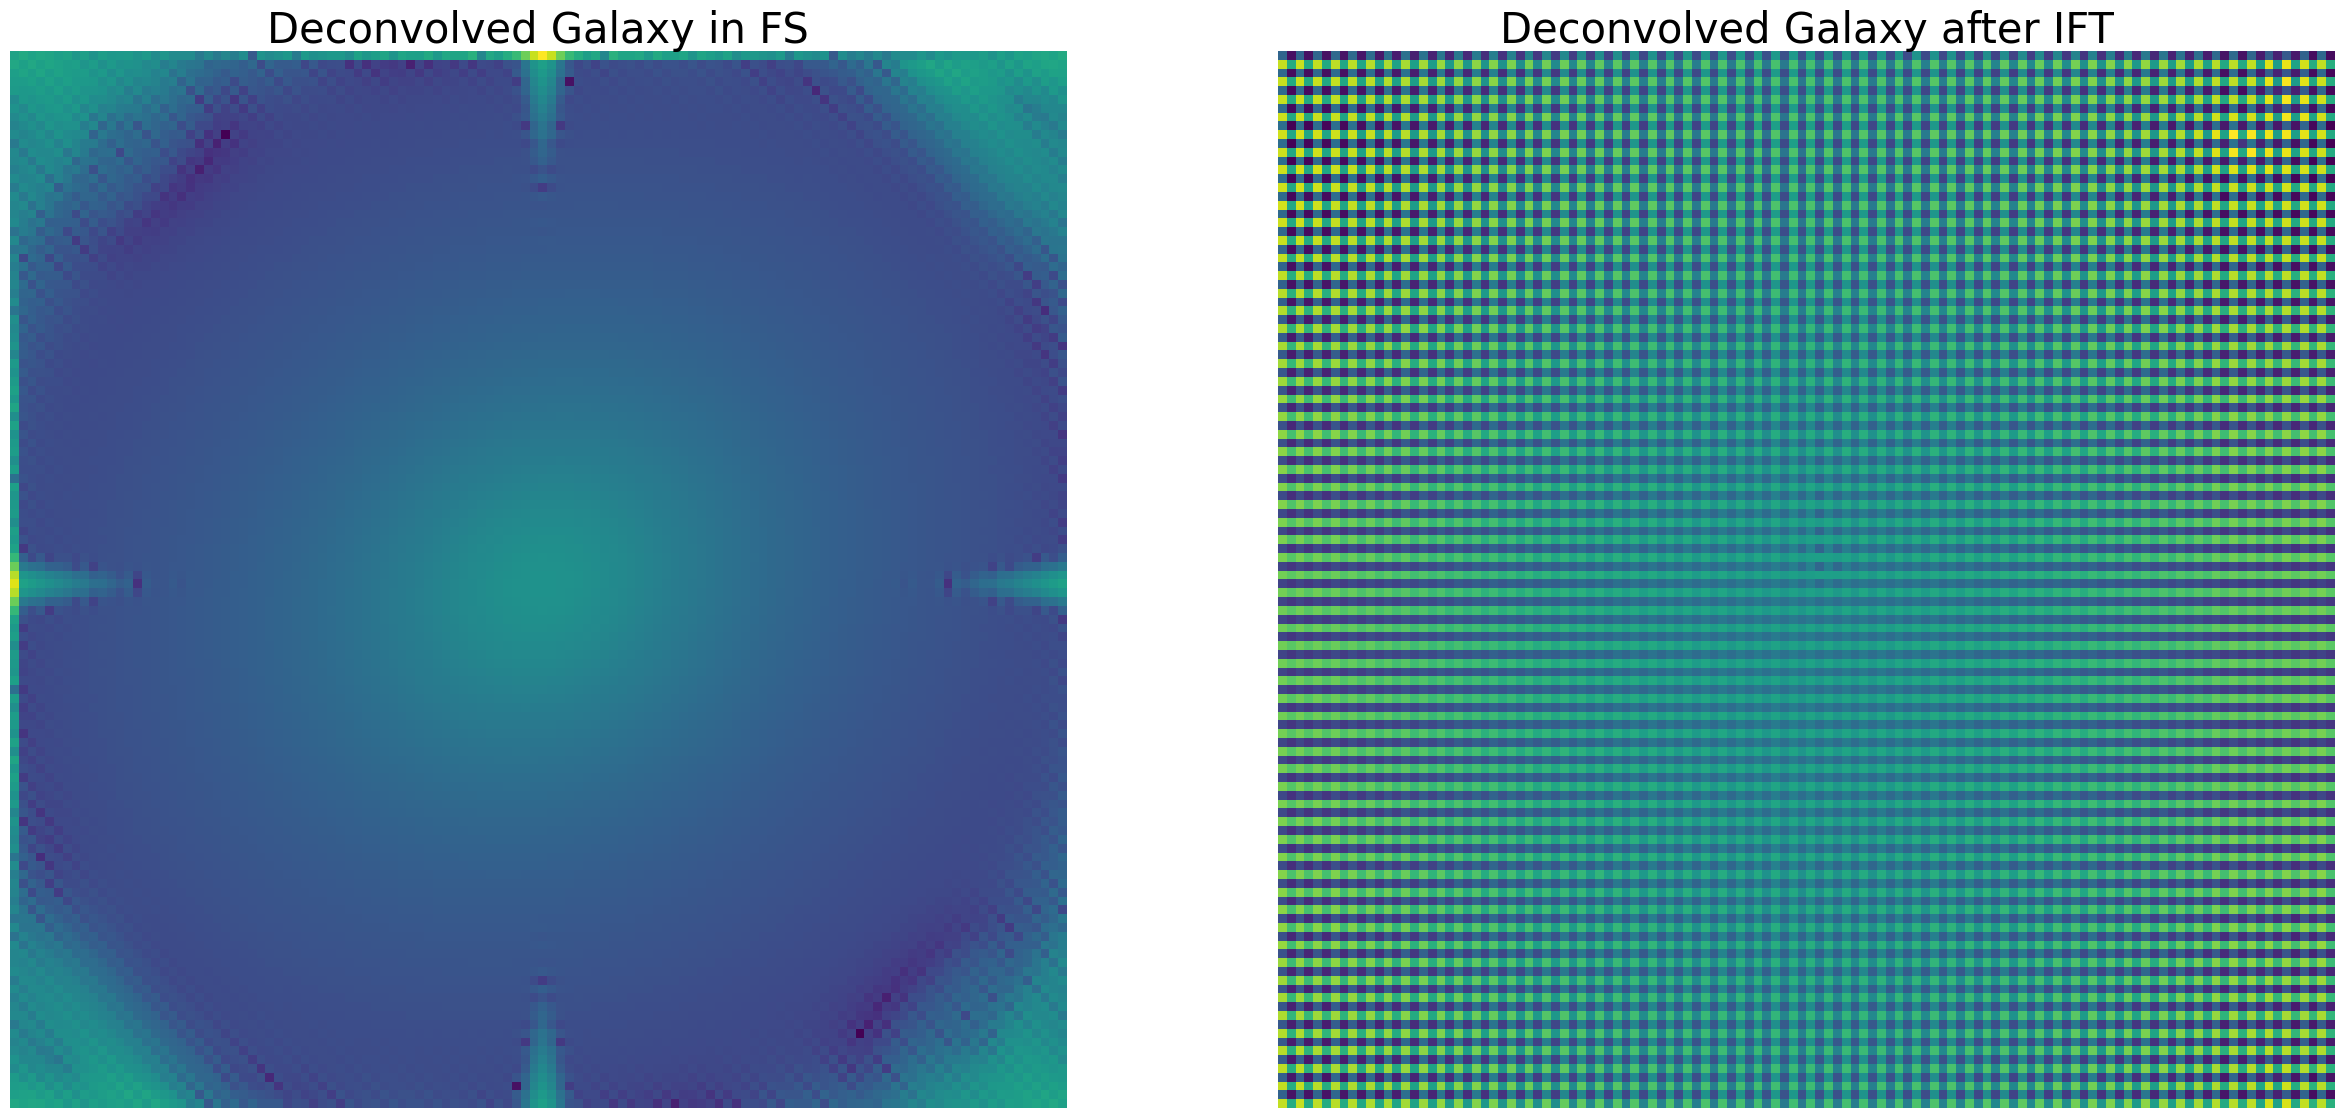

In [11]:
# Deconvolution in FS
#--------------------#
deconv_fs = fshift_gal/fshift_psf
deconv_img = FT_IFT_calc(deconv_fs, FT=False)


def deconv_vis(deconv_fs, deconv_img):
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(30,26))
    axes[0].imshow(np.log(1 + np.abs(deconv_fs)))
    axes[0].axis('off')
    axes[0].set_title('Deconvolved Galaxy in FS', fontsize=30)
    axes[1].imshow(deconv_img.real)
    axes[1].axis('off')
    axes[1].set_title('Deconvolved Galaxy after IFT', fontsize=30)
#     axes[2].imshow(np.log((deconv_img)))
#     axes[2].axis('off')
#     axes[2].set_title('Deconvolved Galaxy after IFT w/ vis help', fontsize=30)
    plt.show()
# plt.imshow(deconv_img)
deconv_vis(deconv_fs, deconv_img)

**Doing some testing on the PSF. I think the problem is that the PSF's FT is close to 0, so we are getting dividing by zero errors. Going to replace the zero/near-zero values with some constant value.** Watched this [video](https://www.youtube.com/watch?v=6gweWmvLa-8) to help figure out what was wrong with the code.

In [12]:
# Test showing we are running into divide by zero when doing the deconvolution in FS
gal = isolated_images[0][0][0]
psf_img = psf_images[0]


GAL = fft.fft2(gal)
PSF = fft.fft2(psf_img)
deconv = GAL / PSF

deconv_img = fft.ifft2(deconv)

/var/folders/kh/07h47s9d6sj9l1d2plg9tzn40000gn/T/ipykernel_50489/3324737403.py:8: RuntimeWarning: divide by zero encountered in divide
  deconv = GAL / PSF


In [13]:
# Test to see how this does when we replace zero/near-zero FT PSF values to a constant value
gal = isolated_images[0][0][0]
psf_img = psf_images[0]

GAL = fft.fft2(gal)
PSF = fft.fft2(psf_img)
PSF[np.abs(PSF) <= 0.0002]  = 0.0002

# Deconvolution/ inverse filtering
deconv_hat = np.divide(GAL, PSF)

deconv_img = fft.ifft2(deconv_hat).real
deconv_img = fft.ifftshift(deconv_img)
# plt.imshow(deconv_img)

/var/folders/kh/07h47s9d6sj9l1d2plg9tzn40000gn/T/ipykernel_50489/197546294.py:17: RuntimeWarning: invalid value encountered in log
  axes[1,2].imshow(np.log(deconv_img))


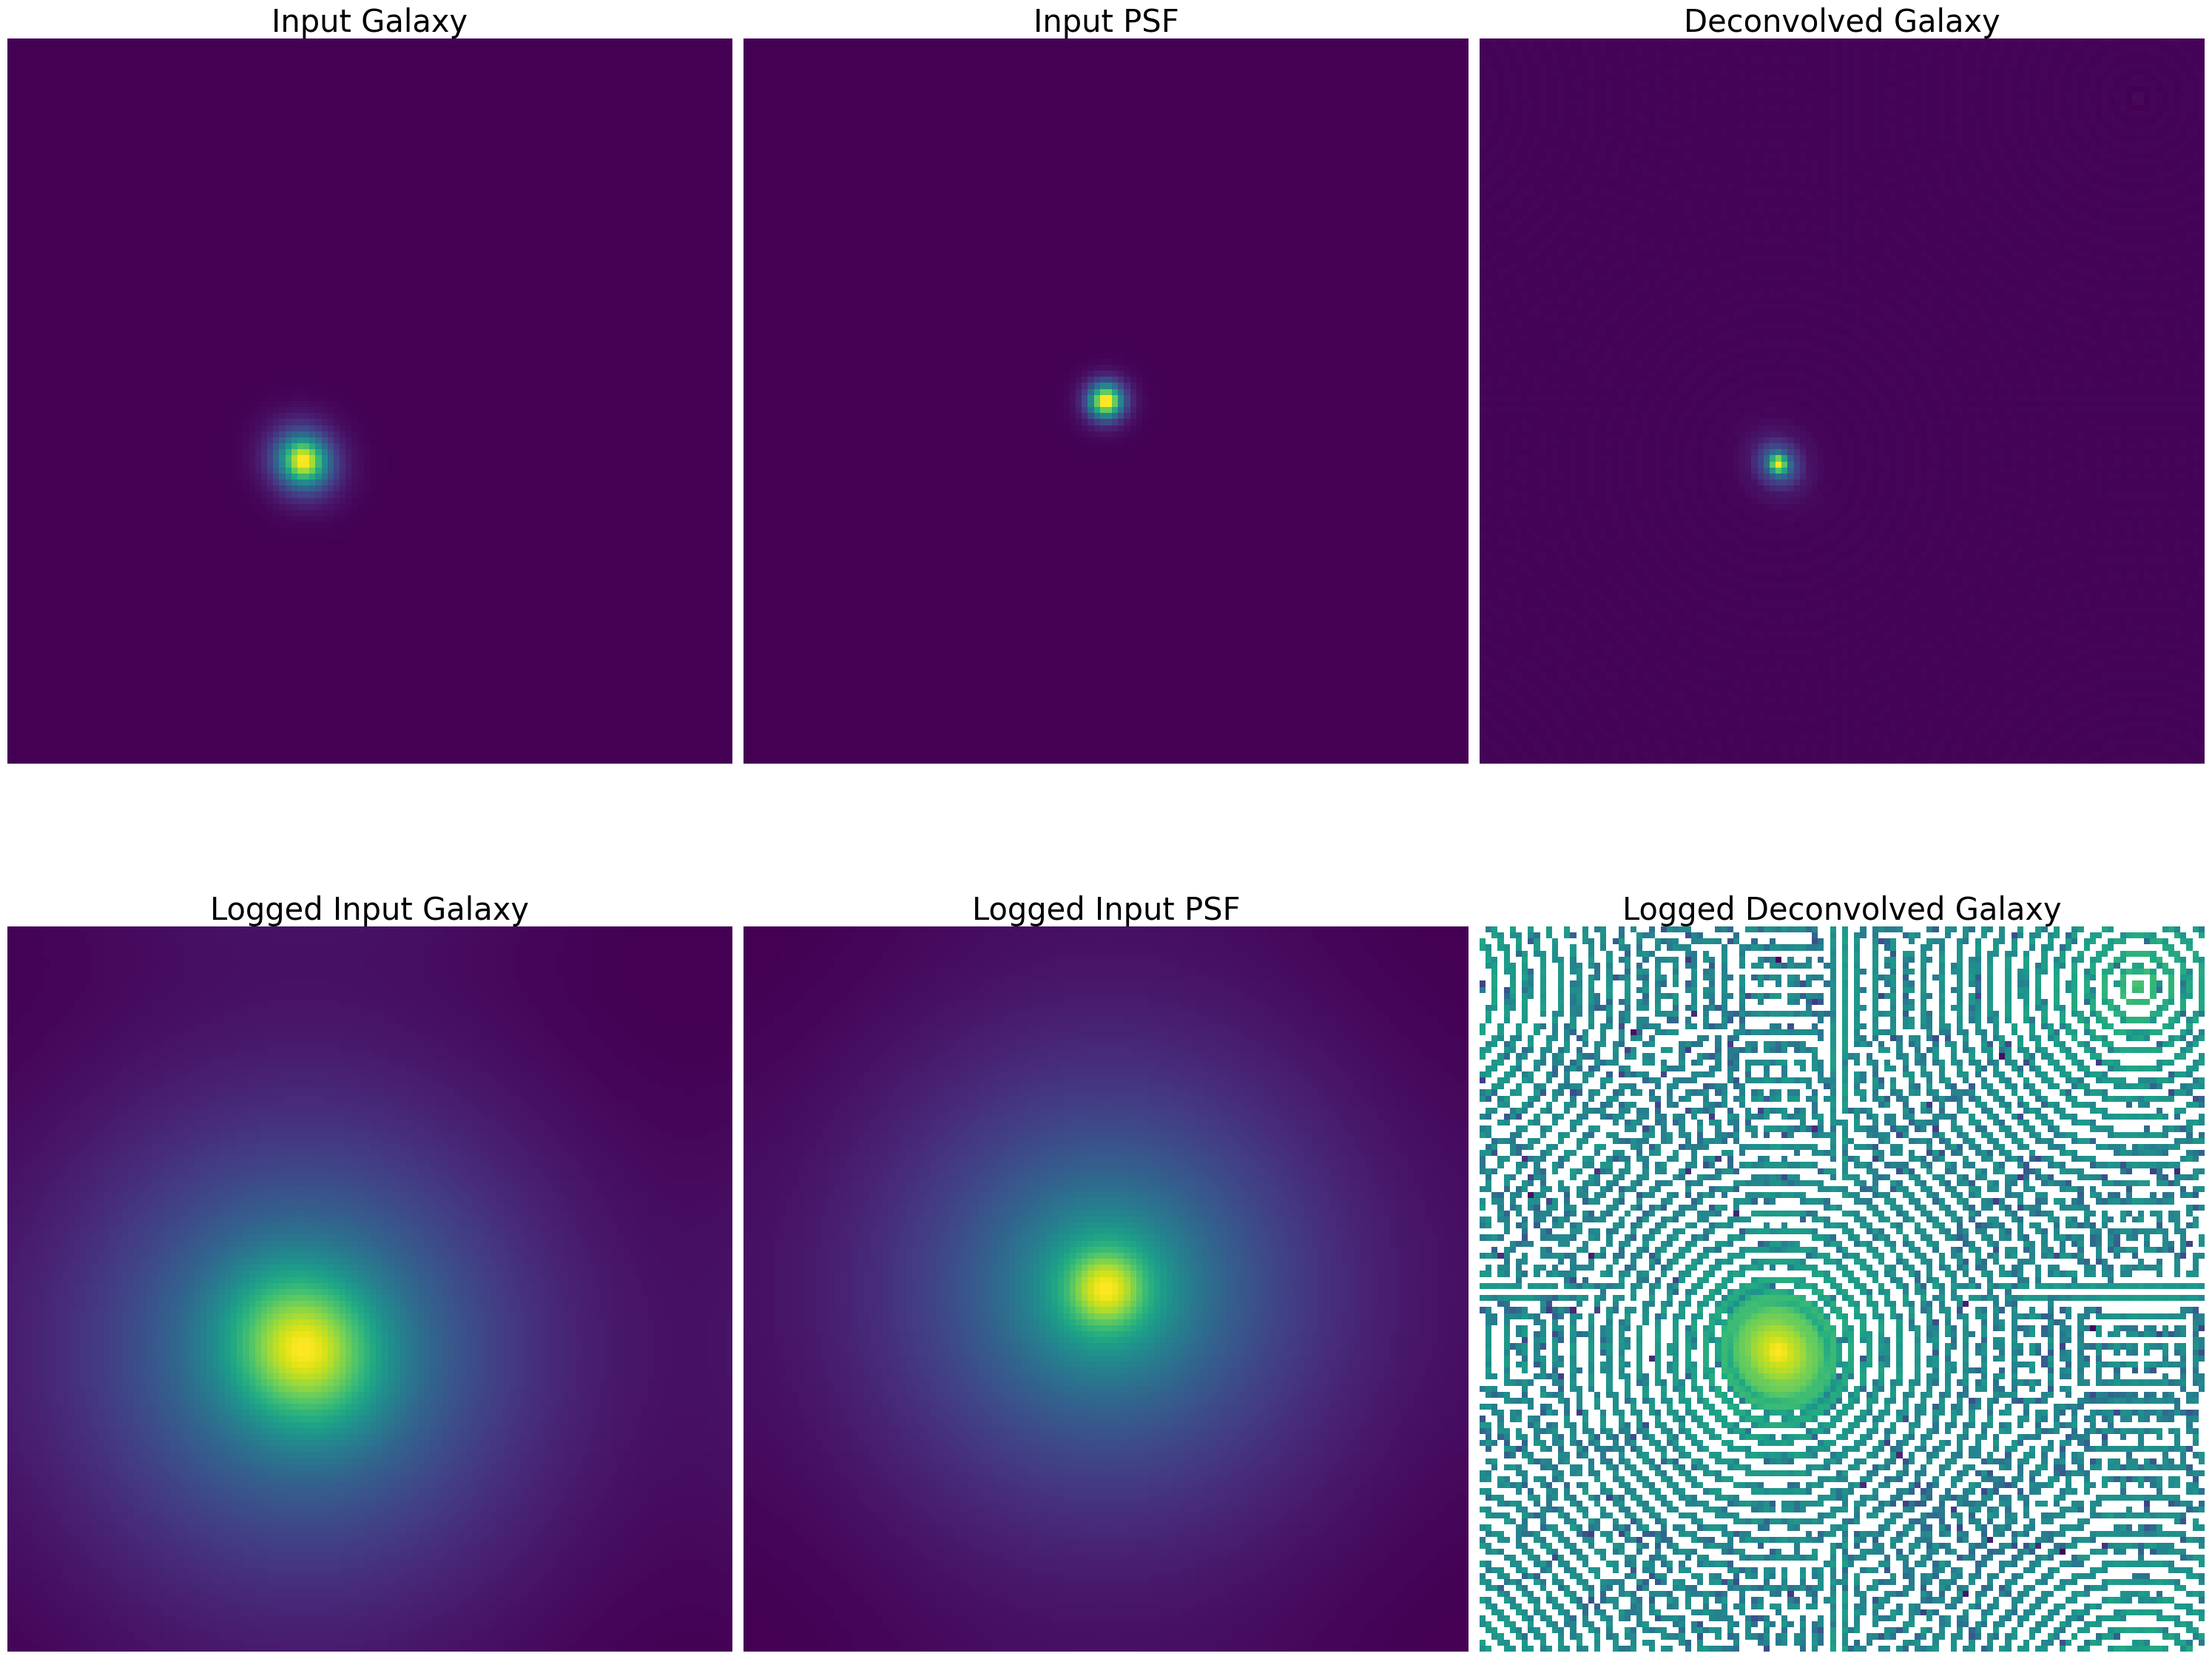

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(30,26))
axes[0,0].imshow(gal)
axes[0,0].axis('off')
axes[0,0].set_title('Input Galaxy', fontsize=30)
axes[0,1].imshow(psf_img)
axes[0,1].axis('off')
axes[0,1].set_title('Input PSF', fontsize=30)
axes[0,2].imshow(deconv_img)
axes[0,2].axis('off')
axes[0,2].set_title('Deconvolved Galaxy', fontsize=30)
axes[1,0].imshow(np.log(gal))
axes[1,0].axis('off')
axes[1,0].set_title('Logged Input Galaxy', fontsize=30)
axes[1,1].imshow(np.log(psf_img))
axes[1,1].axis('off')
axes[1,1].set_title('Logged Input PSF', fontsize=30)
axes[1,2].imshow(np.log(deconv_img))
# axes[1,2].imshow(np.log(1 + np.abs(deconv_img)))
axes[1,2].axis('off')
axes[1,2].set_title('Logged Deconvolved Galaxy', fontsize=30)

fig.tight_layout()
plt.show()

# Old work

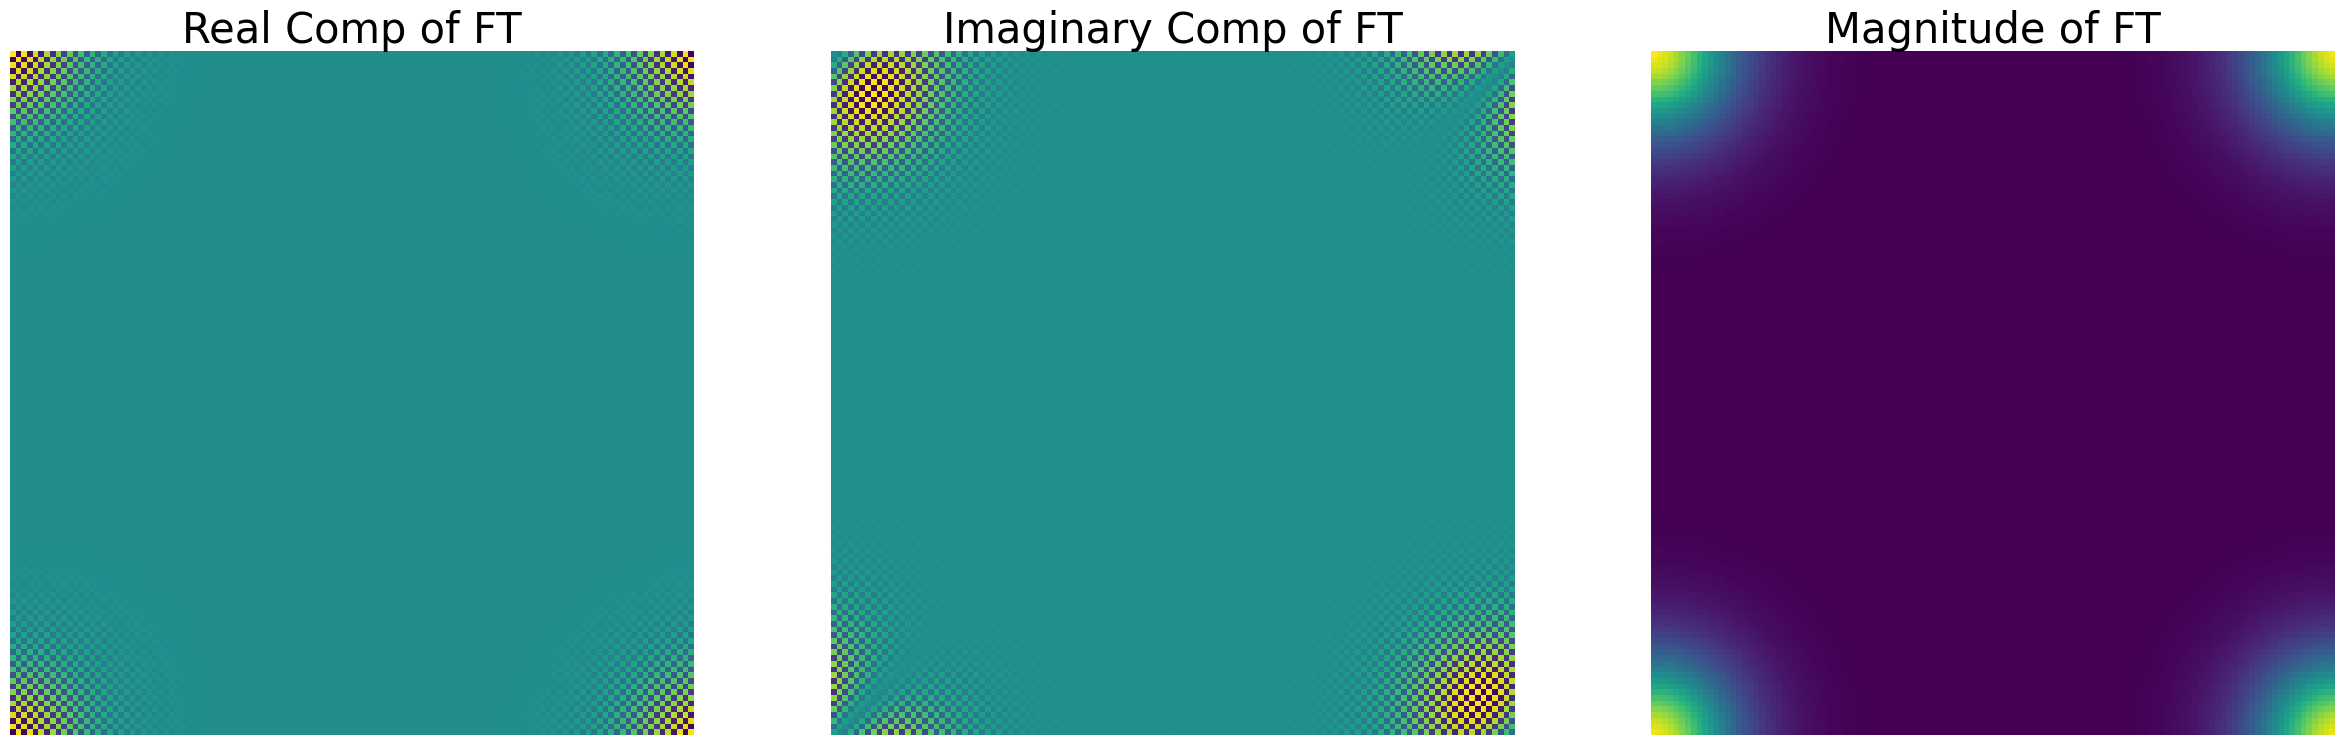

In [60]:
def visualize_FT_comps(ft_img):
    """
    Function to visualize the different FT components ie.
    the real, imaginary, and magnitude.
    """
    fig, axes = plt.subplots(1, 3, figsize=(30,26))
    axes[0].imshow(np.real(ft_img))
    axes[0].axis('off')
    axes[0].set_title('Real Comp of FT', fontsize=30)
    axes[1].imshow(np.imag(ft_img))
    axes[1].axis('off')
    axes[1].set_title('Imaginary Comp of FT', fontsize=30)
    axes[2].imshow(np.abs(ft_img))
    axes[2].axis('off')
    axes[2].set_title('Magnitude of FT', fontsize=30)
    
visualize_FT_comps(psf_ft)

In [ ]:
f = fft.fft2(img)
    fshift = fft.fftshift(f)
    magnitude_spectrum = np.log(1 + np.abs(fshift))
    return f, fshift, magnitude_spectrum

else:
    f_ishift = fft.ifftshift(img)
    ift_img = fft.ifft2(f_ishift)
    ift_img = np.real(ift_img)

In [69]:
f_gal = fft.fft2(gal, norm='forward')
PSF = np.abs(fft.fft2(psf, norm='forward'))
f_psf = fft.fft2(PSF, norm='forward')

deconv_fs = f_gal / f_psf
deconv = fft.ifft2(deconv_ishift, norm='forward')

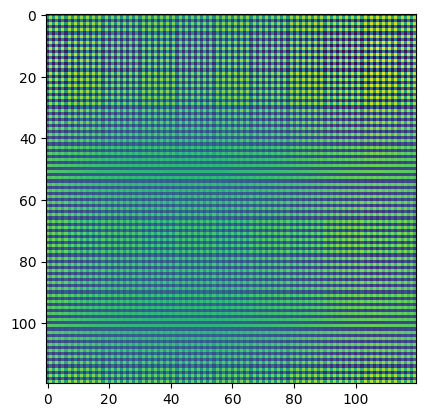

In [72]:
plt.imshow(np.real(deconv))

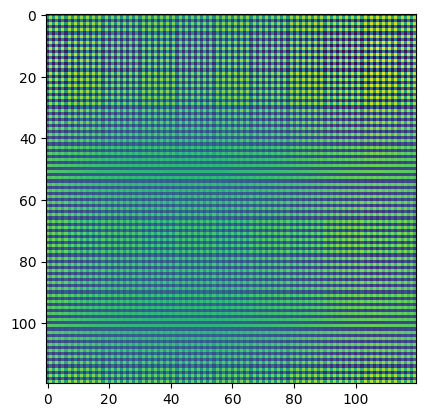

In [58]:
plt.imshow(np.real(deconv))

# Blah

**Plots of FT/IFT of Galaxy images:**

In [15]:
iso_img = isolated_images[0][0][0][46:94, 26:74]
H_gal, W_gal = iso_img.shape
iso_arr = pyfftw.empty_aligned((H_gal, W_gal), dtype=np.float64)
iso_arr[:, :] = iso_img
iso_ft_power = pyfftw.interfaces.numpy_fft.fft2(iso_arr)
iso_ft_mag = np.abs(base_iso_fft)

iso_fft = np.log(1 + iso_ft_mag)
iso_fft = pyfftw.interfaces.numpy_fft.fftshift(iso_fft)

iso_ifft = np.real(pyfftw.interfaces.numpy_fft.ifft2(iso_ft_power))
iso_ifft = pyfftw.interfaces.numpy_fft.ifftshift(iso_ifft)


# Plotting
fig, axes = plt.subplots(1, 3, figsize=(30,26))
axes[0].imshow(iso_img)
axes[0].axis('off')
axes[0].set_title('Input image', fontsize=30)
axes[1].imshow(iso_fft)
axes[1].axis('off')
axes[1].set_title('Galaxy FT', fontsize=30)
axes[2].imshow(iso_ifft)
axes[2].axis('off')
axes[2].set_title('IFT of Galaxy FT', fontsize=30)

plt.tight_layout()
plt.show()

NameError: name 'base_iso_fft' is not defined

In [ ]:
np.allclose(iso_ifft, iso_img)

This plotting cell is to make sure that the pipeline of image $\rightarrow$ FT(image) $\rightarrow$ IFT(FT(image)) $\rightarrow$ image. Also comparing if visualizing the FT differently would effect anything.

In [ ]:
base_fft = np.abs(base_iso_fft)
base_ifft = np.real(pyfftw.interfaces.numpy_fft.ifft2(base_iso_fft))

iso_fft = np.log(1 + np.abs(base_iso_fft))
iso_fft = pyfftw.interfaces.numpy_fft.fftshift(iso_fft)

iso_ifft = np.real(pyfftw.interfaces.numpy_fft.ifft2(base_iso_fft))
iso_ifft = pyfftw.interfaces.numpy_fft.ifftshift(iso_ifft)



# Plotting
fig, axes = plt.subplots(2, 3, figsize=(30,26))
axes[0,0].imshow(base_iso_fft)
axes[0,0].axis('on')
axes[0,0].set_title('Raw galaxy FT', fontsize=30)
axes[0,1].imshow(base_ifft)
axes[0,1].axis('on')
axes[0,1].set_title('Raw galaxy IFT', fontsize=30)
axes[0,2].imshow(iso_img)
axes[0,2].axis('on')
axes[0,2].set_title('Input of FT', fontsize=30)

axes[1,0].imshow(iso_fft)
axes[1,0].axis('off')
axes[1,0].set_title('Galaxy FT w/ visualization', fontsize=30)
axes[1,1].imshow(iso_ifft)
axes[1,1].axis('off')
axes[1,1].set_title('Galaxy IFT w/ vis', fontsize=30)
axes[1,2].imshow(iso_img)
axes[1,2].axis('on')
axes[1,2].set_title('Input of FT', fontsize=30)



plt.tight_layout()
plt.show()

This is weird. I assume it has something to do with regularization? David said that one of the useful aspects of doing this in FS is that we can just make a frequency cut on the images that are making the regularization unstable.

I'm unsure if this is regularization or not?

Also, I'm unsure of this weird grid-pattern occuring? I guess this has to do with the fact the convolution loses some data, thus the deconvolved galaxy will be missing some data or have weird artifacts, but I think the degree to which I'm seeing is too great.

---

Also, from **"Concise CV" textbook**: For better visibilty the spectrum (ie. magnitude/L2 norm) of the FT is normally log-transformed into:

$$log_{10}(1 + ||\mathbf{I}(u,v)||_{2})$$

where,
- $\mathbf{I}(u,v)$ is the FT of the image
- $(u,v)$ are the frequencies. 
    - $u = 0, 1, N_{cols} -1$ and $v = 0, 1,..., N_{rows}-1$. The image coordinates run from $0$ to $N_{cols}-1$ for $x$ and from $0$ to $N_{rows}-1$ for $y$.
- $|| \dot ||_{2}$ is $\sqrt{a^2 + b^2}$

See notebook `02_pyFFTW_testing.ipynb` for more references

In [ ]:
# Isolated galaxy FT 
#--------------------#
# iso_img = isolated_images[0][0][0]
iso_img = isolated_images[0][0][0][46:94, 26:74]
H_gal, W_gal = iso_img.shape
iso_arr = pyfftw.empty_aligned((H_gal, W_gal), dtype=np.float64)
iso_arr[:, :] = iso_img
iso_power = pyfftw.interfaces.numpy_fft.fft2(iso_arr)
iso_mag = np.abs(iso_power) # This is what we use in the IFT
iso_mag_vis = np.log(1 + iso_mag)
iso_mag_vis = pyfftw.interfaces.numpy_fft.fftshift(iso_mag_vis)

# PSF FT 
#-------#
# First need to pad the PSF image, so that the deconvolution in FS 
# (i.e. a division) is able to be done.
psf_img = psf_images[0]
H_psf, W_psf = psf_img.shape
height_diff = int(np.abs(H_gal - H_psf)/2)
width_diff = int(np.abs(W_gal - W_psf)/2)
print(height_diff)
print(width_diff)

psf_img = np.pad(psf_img, ((height_diff, height_diff), (width_diff, width_diff)), 'minimum')
H_psf, W_psf = psf_img.shape # Reset the H/W of the PSF after padding

psf = pyfftw.empty_aligned((H_psf, W_psf), dtype=np.float64)
psf[:, :] = psf_img
psf_power = pyfftw.interfaces.numpy_fft.fft2(psf)
psf_mag = np.abs(psf_power) # This is what we use in the IFT
psf_mag_vis = np.log(1 + psf_mag)
psf_mag_vis = pyfftw.interfaces.numpy_fft.fftshift(psf_mag_vis)


# FS Deconvolution
#-----------------#
deconv = iso_mag/psf_mag
deconv_mag = np.abs(deconv)
deconv_mag_vis = np.log(1 + deconv_mag)
deconv_mag_vis = pyfftw.interfaces.numpy_fft.fftshift(deconv_mag_vis)

# Deconvolved galaxy image
#-------------------------#
# deconv_gal = np.real(pyfftw.interfaces.numpy_fft.ifft2(deconv))
# deconv_gal = np.real(pyfftw.interfaces.numpy_fft.ifft2(deconv_mag))
deconv_gal = pyfftw.interfaces.numpy_fft.ifft2(deconv_mag)
deconv_gal = np.real(pyfftw.interfaces.numpy_fft.ifftshift(deconv_gal))

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(30,26))
axes[0,0].imshow(iso_img)
axes[0,0].axis('on')
axes[0,0].set_title('Input Galaxy: u filter', fontsize=30)
axes[0,1].imshow(psf_img)
axes[0,1].axis('on')
axes[0,1].set_title('Input PSF: u filter', fontsize=30)
axes[0,2].imshow(deconv_gal)
axes[0,2].axis('off')
axes[0,2].set_title('Output Deconv Gal', fontsize=30)
axes[1,0].imshow(np.abs(iso_mag_vis))
axes[1,0].axis('off')
axes[1,0].set_title('Galaxy FT', fontsize=30)
axes[1,1].imshow(psf_mag_vis)
axes[1,1].axis('off')
axes[1,1].set_title('PSF FT', fontsize=30)
axes[1,2].imshow(deconv_mag_vis)
axes[1,2].axis('off')
axes[1,2].set_title('Deconv in FS', fontsize=30)

plt.tight_layout()
plt.show()

In [ ]:
iso_img = isolated_images[0][0][0]
print('Min value of iso_img =', np.min(iso_img))
psf_img = psf_images[0]
print('Min value of psf_img =', np.min(psf_img))


### FT code for diff images (PSF, blend, isolated)

In [ ]:
def calc_fft_spec(img, batch_i=0, gal_i=0, filter_i=0):
    """
    Function to calculate the 2D DFT spectrum for use
    in visualization purposes.
    
    Args:
    -----
        img: np.ndarray
            Either a blended galaxy image or an image of the
            individual galaxies that make up the blended image.
        batch_i: int
            The batch index. The index of the sample you want to
            visualize from the BTK created blended batch. 
            Defaults to the first sample in the batch.
        gal_i: int
            Galaxy index. If there are more than one galaxys in a blend
            this arg allows user specification for which galaxy 2D DFT
            spectrum to plot.
            Defaults to the first galaxy in the blend.
            NOTE: Only needed when calculating DFT for the isolated 
                  galaxies.
        filter_i: int
            Filter index. Which of the 6 LSST filters do you want to
            select for FT spectrum visualization.
            Defaults to 0.
    
    Returns:
    --------
        fft_spec: np.ndarray
            Returns the 2D DFT spectrum of the inputted galaxy image.
            Array will have shape: (H, W)
    """
    
    if isinstance(img, np.ndarray):
        # i.e. if the image is an isolated galaxy image
        if img.ndim == 5:
            input_gal = img[batch_i,gal_i, filter_i]
            H, W = input_gal.shape

            # Create and fill np.float64 array 'img'
            # NOTE: Make the dtype not hard-coded
            img = pyfftw.empty_aligned((H, W), dtype=np.float64) 
            img[:, :] = input_gal
            # 2D DFT of the image
            fft_obj = pyfftw.interfaces.numpy_fft.fft2(img)
            # Take the absolute value of the image ie. get the magnitude of the image
            fft_spectrum = np.abs(fft_obj)
            # Log it for viewing purposes
            fft_spec = np.log(1 + fft_spectrum)
            # Shift the FT so that the DC component is in the center
            fft_spec = pyfftw.interfaces.numpy_fft.fftshift(fft_spec)

            return input_gal, fft_spec

        # i.e. if the image is a blended image
        else:
            input_blend = img[batch_i, filter_i]
            H, W = input_blend.shape

            # Create and fill np.float64 array 'img'
            # Make the dtype not hard-coded
            img = pyfftw.empty_aligned((H, W), dtype=np.float64) 
            img[:, :] = input_blend
            # 2D DFT of the image
            fft_obj = pyfftw.interfaces.numpy_fft.fft2(img)
            # Take the absolute value of the image ie. get the magnitude of the image
            fft_spectrum = np.abs(fft_obj)
            # Log it for viewing purposes
            fft_spec = np.log(1 + fft_spectrum)
            # Shift the FT so that the DC component is in the center
            fft_spec = pyfftw.interfaces.numpy_fft.fftshift(fft_spec)

            return input_blend, fft_spec
        
    # i.e. when wanting the FT of the PSF
    else:
        # PSF input is just a list of PSF images, thus only need the
        # filter index.
        input_psf = img[filter_i]
        H, W = input_psf.shape
        
        # Create and fill np.float64 array 'img'
        img = pyfftw.empty_aligned((H, W), dtype=np.float64)
        img[:, :] = input_psf
        # 2D DFT of the image
        fft_obj = pyfftw.interfaces.numpy_fft.fft2(img)
        # Take the absolute value of the image ie. get the magnitude of the imagee
        fft_spectrum = np.abs(fft_obj)
        # Log it for vieweing purposes
        fft_spec = np.log(1 + fft_spectrum)
        # Shift FT so the DC component is in the center
        fft_spec = pyfftw.interfaces.numpy_fft.fftshift(fft_spec)
        
        return input_psf, fft_spec

In [ ]:
blend_images = batch['blend_images']
isolated_images = batch['isolated_images']
psf_images = create_PSF_image(psf_obj=psf)

In [ ]:
batch_indx = 0
filter_indx = 0

# Get the spatial galaxy image input and the FT of said input galaxy
gal_img, gal_FT = calc_fft_spec(img=isolated_images,
                                        batch_i=batch_indx,
                                        filter_i=filter_indx)

# Get the input PSF and the FT of the inputted PSF
psf_img, psf_FT = calc_fft_spec(img=psf_images,
                                batch_i=batch_indx,
                                filter_i=filter_indx)

# 2. Functions that create the blend and plot `blend_images` and `isolated_images` -- To be used when done with (1.)

In [ ]:
def BTK_blend_generator(catalog_name=None,
                        stamp_size=24.0,
                        max_number=2,
                        max_shift=0.0,
                        batch_size=10,
                        sampling_func=None,
                        survey="LSST",
                        add_noise="all"):
    
    """
    Helper function that puts the necessary pieces together to create
    a 'DrawBlendsGenerator' as shown in the diagram above. The "necessary
    pieces" are all the red boxes that flow into the first blue box.
    
    Args:
    -----
        catalog_name: str
            Path to the data file that you want to use to create the blends.
            Defaults to the OneDegSq.fits file.
        stamp_size: float
            Size of the stamp to be created, in arcseconds.
            Defaults to 24.0 arcseconds.
        max_number: int
            How many galaxies in the blend.
            Defaults to 2.
        max_shift: float
            Max shift of the galaxies from center, in arcseconds.
            Defaults to 0.0
        batch_size: int
            Number of samples you want to create from function call.
            Defaults to 10.
        sampling_func: btk.sampling_functions object
            Sampling function thatis used to produce blend tables.
            Defaults to btk.sampling_function.DefaultSampling()
        survey: str
            Name of the survey that you want to use. Returns specified
            surveys from galcheat extended to contain PSF information.
            Defaults to LSST.
        add_noise: str
            Add Poisson noise to the simulated survey image if requested.
            Defaults to "all".
        
    Returns:
    --------
        blend_images: np.ndarray
            Array containing the blended galaxy stamps.
            Array has shape: (N_samples, N_channels, H, W)
        isolated_images: np.ndarray
            Array containing the noise free individual galaxies
            that make up the blend image.
            Array has shape: (N_samples, max_number, N_channels, H, W)
    """
    
    
    # Catalog:
    #---------#
    if catalog_name == None:
        catalog_name = "/Users/matt/Desktop/UCI_Research/LSST/BLTK/DS_creation/Data/OneDegSq.fits"
        catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
    else:
        catalog_name = str(catalog_name)
        catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)

    # Setting parameter values:
    #-------------------#
    stamp_size = stamp_size # Size of the stamp, in arcseconds
    max_number = max_number # Max number of galaxies in a blend
    max_shift = max_shift # Max shift of the galaxies from center, in arcseconds

    # Sampling Function:
    #-------------------#
    if sampling_func is not None:
        sampling_function = sampling_func
    else:
        sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number,
                                                              stamp_size=stamp_size,
                                                              maxshift=max_shift)

    # Survey
    #-------#
    LSST = btk.survey.get_surveys(str(survey))

    # Draw Blends:
    #-------------#
    draw_generator = btk.draw_blends.CatsimGenerator(
        catalog=catalog,
        sampling_function=sampling_function,
        surveys=LSST,
        batch_size=batch_size,
        stamp_size=stamp_size,
        cpus=1,
        add_noise=str(add_noise), 
        seed=1)

    # Sample the blends from the blends generator:
    #----------------------------------------------#
    batch = next(draw_generator)
    blend_images = batch['blend_images']
    blend_list = batch['blend_list']
    isolated_images = batch['isolated_images']
    
    return blend_images, isolated_images


def iso_blended_plot(blend_images, isolated_images, indx, limits=(30,90)):
    """
    Function to plot the blended image and its constituent isolated
    galaxies in 3 LSST bands (gri) and a sum of all 6 bands.
    
    Args:
    -----
        blend_images: np.array
            The actual blended image with all the noise, as seen from the telescope.
        isolated_images: np.array
            The individual images that make-up the blend_images. These are noise free.
        indx: int
            The index of the sample to plot.
        limits: 
            
    Returns:
    --------
        matplotlib.imshow plot of the blended scene and its isolated galaxies
        in the 3 LSST filters (gri) and a sum of all the 6 bands.
    """
    # Number of galaxies in blend
    num_of_obj = isolated_images.shape[1] 
    
    # Creating the 3 band blend img & the 6-band summed blend img
    avg_blend_img = np.sum(blend_images[indx, :, :, :], axis=0)
    blend_3band = btk.plot_utils.get_rgb_image(blend_images[indx])
    
   
    fig, axes = plt.subplots(2, num_of_obj+1, figsize=(30,26))
    for i in range(num_of_obj+1):
        # First row of images will be the blended image in gri bands
        # and the sum over all bands
        axes[0,0].imshow(blend_3band)
        axes[0,0].set_xlim(limits)
        axes[0,0].set_ylim(limits)
        axes[0,0].axis('off')
        axes[0,0].set_title('Blend: gri bands', fontsize=30)
        axes[1,0].imshow(avg_blend_img)
        axes[1,0].set_xlim(limits)
        axes[1,0].set_ylim(limits)
        axes[1,0].axis('off')
        axes[1,0].set_title('Blend: Sum over bands', fontsize=30)

        # Create as many gri/sum over all band images for the
        # individual galaxies that make up the blended image.
        axes[0,i].imshow(btk.plot_utils.get_rgb_image(isolated_images[indx][i-1]))
        axes[0,i].set_xlim(limits) # set_xlim flips the axeses
        axes[0,i].set_ylim(limits)
        axes[0,i].axis('off')
        axes[0,i].set_title(f'Iso {i}: gri bands', fontsize=30)
        axes[1,i].imshow(np.sum(isolated_images[indx][i-1][:, :, :], axis=0))
        axes[1,i].set_xlim(limits)
        axes[1,i].set_ylim(limits)
        axes[1,i].axis('off')
        axes[1,i].set_title(f'Iso {i}: Sum over bands', fontsize=30)
        
    plt.tight_layout()
    plt.show()

In [ ]:
blend_images, isolated_images = BTK_blend_generator(catalog_name=None,
                                                    stamp_size=24.0,
                                                    max_number=2,
                                                    max_shift=0.0,
                                                    batch_size=10,
                                                    sampling_func=None,
                                                    survey="LSST",
                                                    add_noise="all")

In [ ]:
indx=0
iso_blended_plot(blend_images=blend_images,
                 isolated_images=isolated_images,
                 indx=indx,
                 limits=(30,90))